# GoogleNet on Cifar

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pickle
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

class Inception(nn.Module):

    def __init__(self, in_channels, out_1x1, reduce_3x3, out_3x3, reduce_5x5, out_5x5, out_pool):
        super(Inception, self).__init__()
        
        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_3x3, kernel_size=1),
            nn.Conv2d(reduce_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_5x5, kernel_size=1),
            nn.Conv2d(reduce_5x5, out_5x5, kernel_size=5, padding=2)
        )

        # 3x3 pool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)        
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)
    
    
# Define the GoogleNet model
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(1024, self.num_classes)
   
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = F.relu(x)
        x = self.inception3b(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = F.relu(x)
        x = self.inception4b(x)
        x = F.relu(x)
        x = self.inception4c(x)
        x = F.relu(x)
        x = self.inception4d(x)
        x = F.relu(x)
        x = self.inception4e(x)
        x = F.relu(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = F.relu(x)
        x = self.inception5b(x)
        x = F.relu(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)

        return x 


In [7]:
def show_result(model, num_epoch, show=False, save=False, path='result.png'):
    """  Visualize model predictions for a sample of test data
    
    Args:
    - model (torch.nn.Module): trained PyTorch model
    - num_epoch (int): number of training epochs completed
    - show (bool): whether to display the plot inline (default: False)
    - save (bool): whether to save the plot as an image (default: False)
    - path (str): path to save the plot image (default: 'result.png')
    
    
    """
   
    classes = test_data.classes
    with torch.no_grad():            
        images, labels = next(iter(test_loader))
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Plot correct and incorrect predictions
        correct_idxs = np.where(predicted.cpu() == labels.cpu())[0]
        incorrect_idxs = np.where(predicted.cpu() != labels.cpu())[0]

        # Only show the figure if there are incorrect predictions
        if len(incorrect_idxs) > 1:

            # If there are less than 5 incorrect predictions, adjust the number of subplots accordingly
            n_plots = min(5, len(incorrect_idxs))

             # Create a figure with two rows of plots
            fig, axs = plt.subplots(2, n_plots, figsize=(20, 10))
            fig.suptitle('First row = Correct predictions  and Second row = Incorrect predictions')

            # Plot correct predictions
            for i, idx in enumerate(correct_idxs[:n_plots]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[0, i].imshow(img,interpolation='bicubic')
                axs[0, i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img,dataformats='HWC', 
                                  global_step=num_epoch)

            # Plot incorrect predictions
            for i, idx in enumerate(incorrect_idxs[:n_plots]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[1, i].imshow(img,interpolation='bicubic')
                axs[1, i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HWC', 
                                  global_step=num_epoch)
        else:
            fig, axs = plt.subplots(1, 5, figsize=(20, 10))
            fig.suptitle('Correct Predictions')
            for i, idx in enumerate(correct_idxs[:5]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[i].imshow(img,interpolation='bicubic')
                axs[i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HWC', 
                                  global_step=num_epoch)

        if save:
            fig.savefig(path)
        if show:
            fig.show()
        else:
            plt.close()

def show_loss(hist, show=False, save=False, path='Losses.png'):
    """
    Function to plot and display/save the training and testing loss values over epochs during model training.

    Args:
        hist (dict): Dictionary containing the training and testing loss values over epochs.
        show (bool): Flag to display the plot. Default is False.
        save (bool): Flag to save the plot. Default is False.
        path (str): Path to save the plot. Default is 'Losses.png'.

    Returns:
        None
    """
    # Extract x-axis values (epochs) from the history dictionary
    x = range(len(hist['Test_losses']))

     # Extract y-axis values (losses) from the history dictionary
    y1 = hist['Test_losses']
    y2 = hist['Train_losses']

     # Plot the losses using matplotlib
    plt.plot(x, y1, label='Test_losses')
    plt.plot(x, y2, label='Train_losses')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Set the legend position and display grid
    plt.legend(loc=4)
    plt.grid(True)
    
    # Set the plot layout and save the plot if save  is True
    plt.tight_layout()

    if save:
        plt.savefig(path)
    # Display the plot if show  is True, else close the plot
    if show:
        plt.show()
    else:
        plt.close()

def show_accuracy(hist, show=False, save=False, path='Accuracy.png'):
    """
    Plot the training and validation accuracy over epochs from a history dictionary.

    Parameters:
        hist (dict): A dictionary containing the training and validation accuracy values for each epoch.
        show (bool): Whether to display the plot. Default is False.
        save (bool): Whether to save the plot to a file. Default is False.
        path (str): The file path for saving the plot. Default is 'Accuracy.png'.

    Returns:
        None
    """

     # Extract accuracy values from history dictionary
    x = range(len(hist['Test_accuracy']))

    y1 = hist['Test_accuracy']
    y2 = hist['Train_accuracy']

    # Plot accuracy curves
    plt.plot(x, y1, label='Test_accuracy')
    plt.plot(x, y2, label='Train_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    # Save plot to file if specified
    if save:
        plt.savefig(path)

     # Display plot if specified
    if show:
        plt.show()
    else:
        plt.close()


In [9]:
if __name__ == '__main__':
    # initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = './CIFAR10_data/'
    save_dir = './CIFAR10_SPGoogleNet_results/'
    image_save_dir = './CIFAR10_SPGoogleNet_results/results'

    # create folder if not exist
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(image_save_dir):
        os.mkdir(image_save_dir)

    # training parameters
    batch_size = 128
    learning_rate = 0.01
    epochs = 100    
    
    #Load CIFAR10 dataset

    transform = transforms.Compose([transforms.Pad(2),transforms.RandomCrop(32, padding=4),transforms.ToTensor(),
        transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std  = [ 0.229, 0.224, 0.225 ]) ])

    train_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_data = datasets.CIFAR10(root='./data', train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model = GoogLeNet().to(device)

    # Define the optimizer and loss function
    optimizer = optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9,weight_decay=9e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 10,factor =0.1)
    loss_function = nn.CrossEntropyLoss().to(device)
 
    # Train the model

    
    def weights_init(m):
    # initialise both linear and convolutional layers
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_normal_(m.weight)   
    model.apply(weights_init)
    # tracking variables
    Losses = {}
    Losses['Test_losses'] = []
    Losses['Train_losses'] = []
    Losses['per_epoch_ptimes'] = []
    Losses['total_ptime'] = []
    Accuracy = {}
    Accuracy['Test_accuracy'] = []
    Accuracy['Train_accuracy'] = []
    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_epoch_array = []
        running_train_loss = 0.0
        epoch_start_time = time.time()
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)   
          
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            train_loss = loss_function(outputs, labels)

            # Backward pass
            train_loss.backward()

            # Update the parameters
            optimizer.step()

            running_train_loss += train_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()


        train_epoch_loss = running_train_loss/len(train_loader)    
            
        train_accuracy = 100 * train_correct / train_total    
        # print(f"Training Accuracy: {train_accuracy}%")
        
        
        model.eval()
        test_correct = 0
        test_total = 0
        test_loss_epoch_array = []
        running_test_loss = 0.0        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                test_loss = loss_function(outputs, labels)

                running_test_loss += test_loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
        test_epoch_loss =running_test_loss/len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        # print(f"Testing Accuracy: {test_accuracy}%") 

        
        

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        # print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        # print("Training loss: %.8f, Testing loss: %.8f" % (train_epoch_loss, test_epoch_loss))

        path = image_save_dir + '/CIFAR10_SPGoogleNet_' + str(epoch + 1) + '.png'
        # show_result(model, (epoch + 1), save=True, path=path)

        # record the loss for every epoch
        Losses['Train_losses'].append(train_epoch_loss)
        Losses['Test_losses'].append(test_epoch_loss)
        Losses['per_epoch_ptimes'].append(per_epoch_ptime)
        Accuracy['Test_accuracy'].append(test_accuracy)
        Accuracy['Train_accuracy'].append(train_accuracy)
        scheduler.step(train_loss)
         # Add scalars to TensorBoard
        writer.add_scalar('Loss/Train', train_epoch_loss, epoch)
        writer.add_scalar('Loss/Test', test_epoch_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
        
        # Plot loss and accuracy
        writer.add_scalars('Loss', {'Train': train_epoch_loss, 'Test': test_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
        writer.flush()
        
        
        temp  = scheduler.state_dict()
        Lr = temp['_last_lr'][0]
        
        table_data = [
        ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed','Learning Rate'],
        [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime,f'{ Lr:.8f}']
        ]
        
        # table_data = [
        # ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed'],
        # [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime]
        # ]
        
        # Define colors for each column
        colors = ['\033[31m', '\033[32m', '\033[33m', '\033[34m', '\033[35m', '\033[36m','\033[37m']

        # Print the table with separators and colors
        for i, row in enumerate(table_data):
            for j, col in enumerate(row):
                print(f'| {colors[j]}{str(col).ljust(21)}\033[0m', end='')
            print('|')
            if i == 0:
                print('|', end='')
                for j in range(len(row)):
                    print('-' * 22, end='|')
                print()
        
    end_time = time.time()
    total_ptime = end_time - start_time
    Losses['total_ptime'].append(total_ptime)

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (
        np.mean(Losses['per_epoch_ptimes']), epochs, total_ptime))
    with open(save_dir + '/Losses.pkl', 'wb') as f1:
        pickle.dump(Losses, f1)
    with open(save_dir + '/Accuracy.pkl', 'wb') as f2:
        pickle.dump(Accuracy, f2)

    writer.close()

Files already downloaded and verified


100%|██████████| 391/391 [00:31<00:00, 12.32it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 1 of 100             | 17.404               | 21.61                | 2.1296150681307857   | 1.949401946007451    | 36.04399347305298    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.23it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 2 of 100             | 21.882               | 22.05                | 1.9304728404335354   | 1.9032533108433591   | 36.134467124938965   | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.27it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 3 of 100             | 23.236               | 25.95                | 1.8984470894879393   | 1.8588721163665192   | 35.39755916595459    | 0.01000000           |


100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 4 of 100             | 24.128               | 26.19                | 1.8734303411010587   | 1.8243302287934702   | 35.39220881462097    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.47it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 5 of 100             | 26.134               | 25.51                | 1.8434538197944232   | 1.8525389734702775   | 35.21412920951843    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.29it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 6 of 100             | 27.512               | 28.52                | 1.829328032710668    | 1.80336431913738     | 36.09932589530945    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.48it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 7 of 100             | 28.288               | 28.15                | 1.803052456177714    | 1.7994814024695867   | 35.40017795562744    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.44it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 8 of 100             | 29.036               | 28.59                | 1.776582689846263    | 1.779513565799858    | 35.35055923461914    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.37it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 9 of 100             | 29.448               | 27.45                | 1.7617939747203037   | 1.7940805380857443   | 35.89716410636902    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.56it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 10 of 100            | 30.014               | 29.67                | 1.7514713301378138   | 1.7678650511971004   | 34.88661861419678    | 0.01000000           |


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 11 of 100            | 30.86                | 32.4                 | 1.7226078839558165   | 1.707112911381299    | 34.50895309448242    | 0.01000000           |


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 12 of 100            | 31.456               | 32.05                | 1.7140646877191257   | 1.6662721513192864   | 34.01506781578064    | 0.01000000           |


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 13 of 100            | 32.184               | 31.12                | 1.6906807081168875   | 1.7693992219393766   | 34.420183181762695   | 0.01000000           |


100%|██████████| 391/391 [00:30<00:00, 12.65it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 14 of 100            | 32.798               | 34.72                | 1.6803467987138596   | 1.6559361958805519   | 34.279847621917725   | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.58it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 15 of 100            | 33.752               | 33.15                | 1.656279581587028    | 1.6967996600307995   | 35.265015602111816   | 0.01000000           |


100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 16 of 100            | 34.86                | 38.63                | 1.6336168489797647   | 1.58328753785242     | 36.13697528839111    | 0.01000000           |


100%|██████████| 391/391 [00:32<00:00, 12.06it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 17 of 100            | 35.56                | 35.49                | 1.6229489773435666   | 1.6470531029037283   | 36.50234031677246    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.52it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 18 of 100            | 36.196               | 37.15                | 1.5928812261737522   | 1.5751413695419891   | 34.6195011138916     | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.53it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 19 of 100            | 36.782               | 39.51                | 1.586038198007647    | 1.5242297483395926   | 35.237643003463745   | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.51it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 20 of 100            | 37.38                | 39.84                | 1.5690327785204135   | 1.5316026150425779   | 35.21947121620178    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.28it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 21 of 100            | 38.116               | 38.2                 | 1.556244228806947    | 1.5258930408501927   | 35.88694453239441    | 0.01000000           |


100%|██████████| 391/391 [00:30<00:00, 12.63it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 22 of 100            | 39.028               | 37.96                | 1.5388866702613928   | 1.5567620207991781   | 34.97475838661194    | 0.01000000           |


100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 23 of 100            | 39.51                | 34.74                | 1.5343641292713488   | 1.6389926128749606   | 36.573848485946655   | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.32it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 24 of 100            | 40.144               | 40.39                | 1.5179439017839749   | 1.4798729902581325   | 35.87827658653259    | 0.01000000           |


100%|██████████| 391/391 [00:32<00:00, 12.18it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 25 of 100            | 40.784               | 40.64                | 1.5108596793830853   | 1.521522684942318    | 36.25943851470947    | 0.01000000           |


100%|██████████| 391/391 [00:32<00:00, 12.16it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 26 of 100            | 40.474               | 43.74                | 1.516146482713997    | 1.437000408957276    | 35.59119892120361    | 0.01000000           |


100%|██████████| 391/391 [00:32<00:00, 12.19it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 27 of 100            | 41.576               | 36.27                | 1.4950144339705367   | 1.667828676066821    | 36.04274535179138    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.28it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 28 of 100            | 42.126               | 41.71                | 1.4906722331595847   | 1.481707755523392    | 35.97494888305664    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.41it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 29 of 100            | 43.16                | 42.23                | 1.4752951061634152   | 1.4569772466828552   | 35.38340520858765    | 0.01000000           |


100%|██████████| 391/391 [00:31<00:00, 12.32it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 30 of 100            | 43.962               | 40.69                | 1.4553736378164852   | 1.5442879818662811   | 35.78950119018555    | 0.01000000           |


100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 31 of 100            | 43.59                | 45.48                | 1.4665509169668798   | 1.43717981893805     | 36.54369902610779    | 0.01000000           |


100%|██████████| 391/391 [00:32<00:00, 12.20it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 32 of 100            | 45.424               | 47.95                | 1.425850700234513    | 1.38177636454377     | 35.752591133117676   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 33 of 100            | 45.732               | 45.82                | 1.42576422532806     | 1.4288471725922596   | 37.85193991661072    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.72it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 34 of 100            | 45.878               | 48.52                | 1.4250666189681538   | 1.3447962275034264   | 37.713472843170166   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.71it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 35 of 100            | 46.486               | 47.45                | 1.4138168282521046   | 1.3987608318087421   | 37.863776445388794   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.76it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 36 of 100            | 47.442               | 49.37                | 1.3956010427011554   | 1.350628591790984    | 37.72773742675781    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.66it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 37 of 100            | 48.244               | 45.63                | 1.385737781634416    | 1.4720281121097034   | 38.24957466125488    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.78it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 38 of 100            | 48.682               | 45.67                | 1.3721444140309873   | 1.475260334678843    | 37.73761510848999    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 39 of 100            | 48.76                | 42.99                | 1.376132650448538    | 1.5033692574199242   | 38.22864603996277    | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.24it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 40 of 100            | 49.558               | 51.96                | 1.3595979042980066   | 1.2961529825307145   | 39.37182593345642    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 41 of 100            | 50.192               | 43.71                | 1.349011980968973    | 1.4924167198470877   | 38.25355839729309    | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 42 of 100            | 50.938               | 49.68                | 1.339404831152133    | 1.3560241264632986   | 39.333200216293335   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.81it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 43 of 100            | 51.488               | 51.26                | 1.3225195816410777   | 1.2993469917321507   | 37.4118127822876     | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 44 of 100            | 51.51                | 49.42                | 1.314413504527353    | 1.395517729505708    | 38.71772646903992    | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 45 of 100            | 51.778               | 47.16                | 1.3222739230031553   | 1.4579971711846846   | 38.635725259780884   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.55it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 46 of 100            | 51.734               | 52.85                | 1.3213326528554072   | 1.2751714745654334   | 38.20357322692871    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 47 of 100            | 52.784               | 52.55                | 1.290796603997955    | 1.3067442254175115   | 38.16823196411133    | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.41it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 48 of 100            | 52.87                | 49.39                | 1.3009802061883384   | 1.3902198589300807   | 37.946452140808105   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 49 of 100            | 52.654               | 54.8                 | 1.299002532154093    | 1.2545152117934408   | 38.16674089431763    | 0.00100000           |


100%|██████████| 391/391 [00:34<00:00, 11.42it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 50 of 100            | 61.08                | 60.33                | 1.0716249191242715   | 1.0865491998346546   | 38.676812171936035   | 0.00100000           |


100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 51 of 100            | 63.182               | 61.81                | 1.017705534730116    | 1.056859462321559    | 38.6507670879364     | 0.00100000           |


100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 52 of 100            | 63.66                | 61.72                | 1.0030416884385716   | 1.0613832488844666   | 38.302597761154175   | 0.00100000           |


100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 53 of 100            | 64.272               | 62.4                 | 0.9910516519375774   | 1.0362388393546962   | 37.38440465927124    | 0.00100000           |


100%|██████████| 391/391 [00:33<00:00, 11.64it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 54 of 100            | 65.176               | 64.03                | 0.9668053682807767   | 1.011608759813671    | 38.039655923843384   | 0.00100000           |


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 55 of 100            | 65.294               | 64.22                | 0.9633277139395399   | 1.0078518979157074   | 38.11234211921692    | 0.00100000           |


100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 56 of 100            | 65.782               | 64.15                | 0.9528869965192303   | 0.9912298646154283   | 38.277271032333374   | 0.00100000           |


100%|██████████| 391/391 [00:33<00:00, 11.72it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 57 of 100            | 65.97                | 64.81                | 0.9526267920613594   | 0.9931636490399325   | 37.862208127975464   | 0.00100000           |


100%|██████████| 391/391 [00:31<00:00, 12.23it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 58 of 100            | 66.536               | 64.33                | 0.9421622402527753   | 1.0024300504334365   | 35.09494757652283    | 0.00100000           |


100%|██████████| 391/391 [00:31<00:00, 12.50it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 59 of 100            | 66.946               | 65.27                | 0.9366449318883364   | 0.9839184850077086   | 35.58865237236023    | 0.00100000           |


100%|██████████| 391/391 [00:31<00:00, 12.36it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 60 of 100            | 66.774               | 65.42                | 0.9385615919557069   | 0.9872685286063182   | 35.756312131881714   | 0.00100000           |


100%|██████████| 391/391 [00:32<00:00, 12.17it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 61 of 100            | 67.262               | 64.76                | 0.921445084502325    | 1.001172648954995    | 36.299546003341675   | 0.00100000           |


100%|██████████| 391/391 [00:32<00:00, 12.06it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 62 of 100            | 67.464               | 65.02                | 0.9234468943017828   | 0.9941978892193565   | 36.36205244064331    | 0.00010000           |


100%|██████████| 391/391 [00:34<00:00, 11.45it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 63 of 100            | 70.508               | 66.88                | 0.8457353493136823   | 0.9403248135047623   | 38.27194952964783    | 0.00010000           |


100%|██████████| 391/391 [00:32<00:00, 12.13it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 64 of 100            | 71.108               | 67.79                | 0.8282960949041654   | 0.9350088193446775   | 36.38441801071167    | 0.00010000           |


100%|██████████| 391/391 [00:32<00:00, 12.18it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 65 of 100            | 71.21                | 67.69                | 0.8243890372688508   | 0.9292526712900475   | 36.65947771072388    | 0.00010000           |


100%|██████████| 391/391 [00:33<00:00, 11.82it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 66 of 100            | 71.614               | 67.22                | 0.8193340344197305   | 0.9340716283532637   | 37.26954984664917    | 0.00010000           |


100%|██████████| 391/391 [00:32<00:00, 11.92it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 67 of 100            | 71.704               | 67.74                | 0.8143048914497161   | 0.9157412633111205   | 36.91488194465637    | 0.00010000           |


100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 68 of 100            | 71.57                | 67.53                | 0.8124223581665312   | 0.9255467215670815   | 36.88769316673279    | 0.00010000           |


100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 69 of 100            | 71.646               | 68.07                | 0.8113937653848887   | 0.927197325078747    | 36.61550426483154    | 0.00010000           |


100%|██████████| 391/391 [00:31<00:00, 12.34it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 70 of 100            | 72.042               | 67.88                | 0.80460509086204     | 0.9175293611574776   | 34.995227336883545   | 0.00010000           |


100%|██████████| 391/391 [00:32<00:00, 12.17it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 71 of 100            | 71.858               | 67.74                | 0.8021407131953617   | 0.9279827573631383   | 36.239256381988525   | 0.00010000           |


100%|██████████| 391/391 [00:33<00:00, 11.77it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 72 of 100            | 72.08                | 68.03                | 0.801160319229526    | 0.9153754416900345   | 36.41595816612244    | 0.00010000           |


100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 74 of 100            | 72.194               | 68.61                | 0.7938210761455624   | 0.9124303739282149   | 36.6294949054718     | 0.00010000           |


100%|██████████| 391/391 [00:32<00:00, 12.20it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 75 of 100            | 72.63                | 68.7                 | 0.787957838276768    | 0.9052910367144814   | 36.22506785392761    | 0.00010000           |


100%|██████████| 391/391 [00:32<00:00, 12.06it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 76 of 100            | 72.776               | 68.2                 | 0.7842847921354387   | 0.9092855996723417   | 36.48010182380676    | 0.00010000           |


100%|██████████| 391/391 [00:31<00:00, 12.32it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 77 of 100            | 72.544               | 68.78                | 0.7844717533082304   | 0.8981955428666706   | 35.6904079914093     | 0.00010000           |


100%|██████████| 391/391 [00:31<00:00, 12.55it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 78 of 100            | 72.822               | 68.42                | 0.7835191535522871   | 0.9037537318241747   | 35.2911581993103     | 0.00010000           |


100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 79 of 100            | 72.816               | 68.59                | 0.7803038245881609   | 0.9057092674170868   | 34.4199743270874     | 0.00010000           |


100%|██████████| 391/391 [00:31<00:00, 12.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 80 of 100            | 73.25                | 68.42                | 0.7752355629830714   | 0.9235224588007866   | 35.092806816101074   | 0.00010000           |


100%|██████████| 391/391 [00:30<00:00, 12.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 81 of 100            | 73.064               | 68.75                | 0.7759591735842283   | 0.9163982792745663   | 34.734721422195435   | 0.00010000           |


100%|██████████| 391/391 [00:31<00:00, 12.33it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 82 of 100            | 73.366               | 68.77                | 0.7708936399206177   | 0.9098257784602009   | 35.60316443443298    | 0.00010000           |


100%|██████████| 391/391 [00:30<00:00, 12.66it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 83 of 100            | 73.248               | 68.65                | 0.7746871150363132   | 0.9230728866178778   | 34.709054470062256   | 0.00010000           |


100%|██████████| 391/391 [00:31<00:00, 12.47it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 84 of 100            | 73.248               | 68.43                | 0.7705329301412148   | 0.9163776273968853   | 35.41618514060974    | 0.00010000           |


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 85 of 100            | 73.266               | 68.34                | 0.7682032393067694   | 0.9187064095388485   | 34.78497648239136    | 0.00010000           |


100%|██████████| 391/391 [00:30<00:00, 12.66it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 86 of 100            | 73.632               | 69.05                | 0.7629393354401259   | 0.9166270735897596   | 34.8157012462616     | 0.00010000           |


100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 87 of 100            | 73.67                | 68.33                | 0.7640218365832668   | 0.9173001790348487   | 34.680201053619385   | 0.00010000           |


100%|██████████| 391/391 [00:31<00:00, 12.58it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 88 of 100            | 73.548               | 68.61                | 0.7594342756149409   | 0.9167482475691204   | 34.8335337638855     | 0.00010000           |


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 89 of 100            | 73.486               | 68.99                | 0.7601774177892738   | 0.9075757325450077   | 34.344653606414795   | 0.00010000           |


100%|██████████| 391/391 [00:30<00:00, 12.62it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 90 of 100            | 73.744               | 68.72                | 0.7585216591425259   | 0.9054468470283702   | 34.89738488197327    | 0.00010000           |


100%|██████████| 391/391 [00:31<00:00, 12.53it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 91 of 100            | 73.858               | 69.43                | 0.7538869986143868   | 0.9003071732158903   | 35.13575220108032    | 0.00010000           |


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 92 of 100            | 74.02                | 68.37                | 0.7528559899391116   | 0.91862830255605     | 34.6242778301239     | 0.00001000           |


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 93 of 100            | 74.356               | 69.25                | 0.7403525469248252   | 0.8947948255116427   | 34.272767305374146   | 0.00001000           |


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 94 of 100            | 74.432               | 70.04                | 0.7363347999580071   | 0.8909377734872359   | 34.67952013015747    | 0.00001000           |


100%|██████████| 391/391 [00:31<00:00, 12.43it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 95 of 100            | 74.556               | 69.75                | 0.7323260898785213   | 0.892245858530455    | 35.27203345298767    | 0.00001000           |


100%|██████████| 391/391 [00:31<00:00, 12.28it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 96 of 100            | 74.4                 | 69.15                | 0.7382614352666509   | 0.8927937972394726   | 36.014782190322876   | 0.00001000           |


100%|██████████| 391/391 [00:31<00:00, 12.58it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 97 of 100            | 74.61                | 69.63                | 0.7345249294624914   | 0.8906484382062019   | 35.07216262817383    | 0.00001000           |


100%|██████████| 391/391 [00:31<00:00, 12.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 98 of 100            | 74.666               | 69.35                | 0.7306558114793295   | 0.8896034458015538   | 35.04386854171753    | 0.00001000           |


100%|██████████| 391/391 [00:31<00:00, 12.59it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 99 of 100            | 74.782               | 69.6                 | 0.732953666649816    | 0.8813956538333169   | 35.03858828544617    | 0.00001000           |


100%|██████████| 391/391 [00:31<00:00, 12.38it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 100 of 100           | 74.75                | 69.39                | 0.7305690028783306   | 0.8925704443002049   | 34.779137134552      | 0.00001000           |
Avg per epoch ptime: 36.22, total 100 epochs ptime: 3622.10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

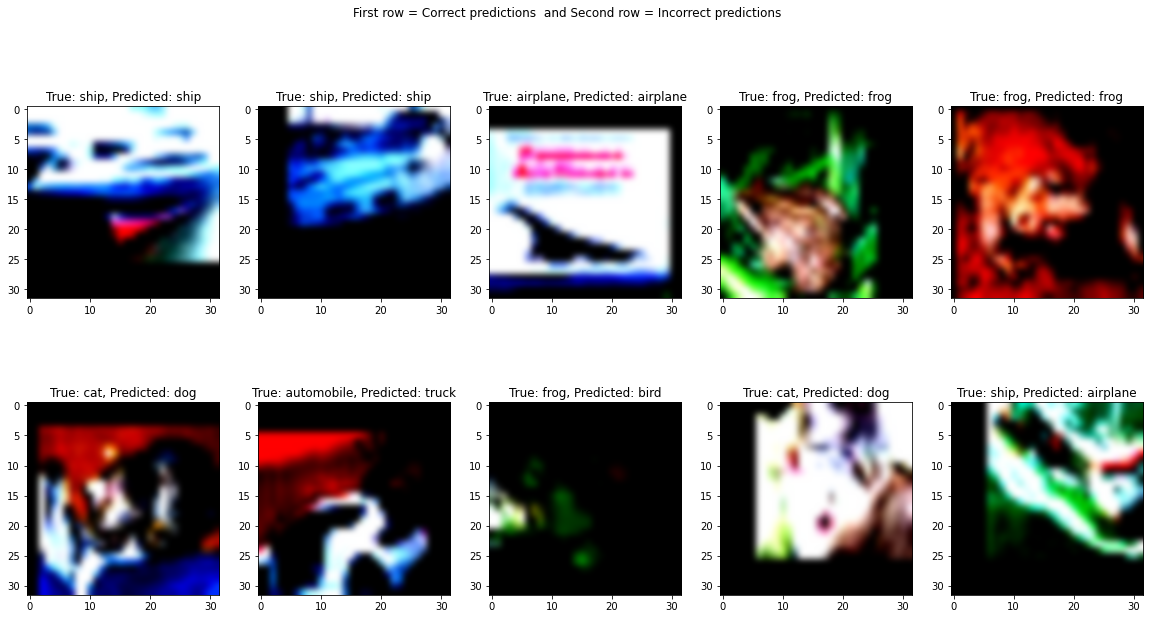

In [10]:
show_loss(Losses, save=True, path=save_dir + '/CIFAR_SPGoogleNet_Losses.png')
show_accuracy(Accuracy, save=True, path=save_dir + '/CIFAR_SPGoogleNet_Accuracy.png')
show_result(model, (epoch + 1),show = True, save=True, path=path)

# GoogleNet on MNIST

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pickle
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

class Inception(nn.Module):

    def __init__(self, in_channels, out_1x1, reduce_3x3, out_3x3, reduce_5x5, out_5x5, out_pool):
        super(Inception, self).__init__()
        
        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_3x3, kernel_size=1),
            nn.Conv2d(reduce_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_5x5, kernel_size=1),
            nn.Conv2d(reduce_5x5, out_5x5, kernel_size=5, padding=2)
        )

        # 3x3 pool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)
    
    
# Define the GoogleNet model
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(1024, self.num_classes)
   
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = F.relu(x)
        x = self.inception3b(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = F.relu(x)
        x = self.inception4b(x)
        x = F.relu(x)
        x = self.inception4c(x)
        x = F.relu(x)
        x = self.inception4d(x)
        x = F.relu(x)
        x = self.inception4e(x)
        x = F.relu(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = F.relu(x)
        x = self.inception5b(x)
        x = F.relu(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)

        return x



   


In [17]:
   
def show_result(model, num_epoch, show=False, save=False, path='result.png'):
    """  Visualize model predictions for a sample of test data
    
    Args:
    - model (torch.nn.Module): trained PyTorch model
    - num_epoch (int): number of training epochs completed
    - show (bool): whether to display the plot inline (default: False)
    - save (bool): whether to save the plot as an image (default: False)
    - path (str): path to save the plot image (default: 'result.png')
    
    
    """
    # Evaluate model predictions on a sample of test data
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

         # Separate correct and incorrect predictions
        correct_idxs = np.where(predicted.cpu() == labels.cpu())[0]
        incorrect_idxs = np.where(predicted.cpu() != labels.cpu())[0]

        # Only show the figure if there are incorrect predictions
        if len(incorrect_idxs) > 1:
            
            # If there are less than 5 incorrect predictions, adjust the number of subplots accordingly
            n_plots = min(5, len(incorrect_idxs))
            
            # Create a figure with two rows of plots
            fig, axs = plt.subplots(2, n_plots, figsize=(20, 10))
            fig.suptitle('First row = Correct predictions  and Second row = Incorrect predictions')

            # Plot correct predictions  in the first row
            for i, idx in enumerate(correct_idxs[:n_plots]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[0, i].imshow(img, cmap="gray",interpolation='bicubic')
                axs[0, i].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)
                
            # Plot incorrect predictions in the second row
            for i, idx in enumerate(incorrect_idxs[:n_plots]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[1, i].imshow(img, cmap="gray",interpolation='bicubic')
                axs[1, i].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)

        elif len(incorrect_idxs) == 1:
            fig, axs = plt.subplots(2, 1, figsize=(20, 10))
            fig.suptitle('First row = Correct predictions  and Second row = Incorrect predictions')

            # Plot correct predictions  in the first row
            for i, idx in enumerate(correct_idxs[:1]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[0].imshow(img, cmap="gray",interpolation='bicubic')
                axs[0].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)

            # Plot incorrect predictions in the second row
            for i, idx in enumerate(incorrect_idxs[:1]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[1].imshow(img, cmap="gray",interpolation='bicubic')
                axs[1].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                 global_step=num_epoch)
        else:
            
            # Create a figure with a single row of correct prediction plots
            fig, axs = plt.subplots(1, 5, figsize=(20, 10))
            fig.suptitle('Correct Predictions')
            
            # Plot correct predictions in the single row
            for i, idx in enumerate(correct_idxs[:5]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[i].imshow(img, cmap="gray",interpolation='bicubic')
                axs[i].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)
        # Save or show the figure
        if save:
            fig.savefig(path)
        if show:
            fig.show()
        else:
            plt.close()

def show_loss(hist, show=False, save=False, path='Losses.png'):
    """
    Function to plot and display/save the training and testing loss values over epochs during model training.

    Args:
        hist (dict): Dictionary containing the training and testing loss values over epochs.
        show (bool): Flag to display the plot. Default is False.
        save (bool): Flag to save the plot. Default is False.
        path (str): Path to save the plot. Default is 'Losses.png'.

    Returns:
        None
    """
    # Extract x-axis values (epochs) from the history dictionary
    x = range(len(hist['Test_losses']))

     # Extract y-axis values (losses) from the history dictionary
    y1 = hist['Test_losses']
    y2 = hist['Train_losses']

     # Plot the losses using matplotlib
    plt.plot(x, y1, label='Test_losses')
    plt.plot(x, y2, label='Train_losses')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Set the legend position and display grid
    plt.legend(loc=4)
    plt.grid(True)
    
    # Set the plot layout and save the plot if save  is True
    plt.tight_layout()

    if save:
        plt.savefig(path)
    # Display the plot if show  is True, else close the plot
    if show:
        plt.show()
    else:
        plt.close()

def show_accuracy(hist, show=False, save=False, path='Accuracy.png'):
    """
    Plot the training and validation accuracy over epochs from a history dictionary.

    Parameters:
        hist (dict): A dictionary containing the training and validation accuracy values for each epoch.
        show (bool): Whether to display the plot. Default is False.
        save (bool): Whether to save the plot to a file. Default is False.
        path (str): The file path for saving the plot. Default is 'Accuracy.png'.

    Returns:
        None
    """

     # Extract accuracy values from history dictionary
    x = range(len(hist['Test_accuracy']))

    y1 = hist['Test_accuracy']
    y2 = hist['Train_accuracy']

    # Plot accuracy curves
    plt.plot(x, y1, label='Test_accuracy')
    plt.plot(x, y2, label='Train_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    # Save plot to file if specified
    if save:
        plt.savefig(path)

     # Display plot if specified
    if show:
        plt.show()
    else:
        plt.close()

In [18]:
if __name__ == '__main__':
    # initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = './MNIST_data/'
    save_dir = './MNIST_SGoogleNet_results/'
    image_save_dir = './MNIST_SGoogleNet_results/results'

    # create folder if not exist
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(image_save_dir):
        os.mkdir(image_save_dir)

    # training parameters
    batch_size = 128
    learning_rate = 0.01
    epochs = 30    
    
    #Load MNIST dataset

    transform = transforms.Compose([transforms.Pad(2),transforms.RandomCrop(32, padding=4),transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) ])

    train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_data = datasets.MNIST(root='./data', train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model = GoogLeNet().to(device)

    # Define the optimizer and loss function
    optimizer = optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9,weight_decay=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 6,factor =0.1)
    loss_function = nn.CrossEntropyLoss().to(device)
 
    # Train the model

    
    def weights_init(m):
    # initialise both linear and convolutional layers
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_normal_(m.weight)   
    model.apply(weights_init)
    # tracking variables
    Losses = {}
    Losses['Test_losses'] = []
    Losses['Train_losses'] = []
    Losses['per_epoch_ptimes'] = []
    Losses['total_ptime'] = []
    Accuracy = {}
    Accuracy['Test_accuracy'] = []
    Accuracy['Train_accuracy'] = []
    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_epoch_array = []
        running_train_loss = 0.0
        epoch_start_time = time.time()
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)   
          
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            train_loss = loss_function(outputs, labels)

            # Backward pass
            train_loss.backward()

            # Update the parameters
            optimizer.step()
            # scheduler.step(train_loss)

            running_train_loss += train_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
           
        train_epoch_loss = running_train_loss/len(train_loader)   
        train_accuracy = 100 * train_correct / train_total    
        # print(f"Training Accuracy: {train_accuracy}%")
        
        
        model.eval()
        test_correct = 0
        test_total = 0
        test_loss_epoch_array = []
        running_test_loss = 0.0        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                test_loss = loss_function(outputs, labels)
                
                # # Backward pass
                # test_loss.backward()
                running_test_loss += test_loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_epoch_loss =  running_test_loss/len(test_loader)       
        test_accuracy = 100 * test_correct / test_total
        # print(f"Testing Accuracy: {test_accuracy}%") 

        
        
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        # print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        # print("Training loss: %.8f, Testing loss: %.8f" % (train_epoch_loss, test_epoch_loss))

        path = image_save_dir + '/MNIST_GoogleNet_' + str(epoch + 1) + '.png'
        # show_result(model, (epoch + 1), save=True, path=path)

        # record the loss for every epoch
        Losses['Train_losses'].append(train_epoch_loss)
        Losses['Test_losses'].append(test_epoch_loss)
        Losses['per_epoch_ptimes'].append(per_epoch_ptime)
        Accuracy['Test_accuracy'].append(test_accuracy)
        Accuracy['Train_accuracy'].append(train_accuracy)
        scheduler.step(train_loss)
         # Add scalars to TensorBoard
        writer.add_scalar('Loss/Train', train_epoch_loss, epoch)
        writer.add_scalar('Loss/Test', test_epoch_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
        
        # Plot loss and accuracy
        writer.add_scalars('Loss', {'Train': train_epoch_loss, 'Test': test_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
        writer.flush()
        
        temp  = scheduler.state_dict()
        Lr = temp['_last_lr'][0]
        
        table_data = [
        ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed','Learning Rate'],
        [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime,f'{ Lr:.8f}']
        ]
        
        # Define colors for each column
        colors = ['\033[31m', '\033[32m', '\033[33m', '\033[34m', '\033[35m', '\033[36m','\033[37m']

        # Print the table with separators and colors
        for i, row in enumerate(table_data):
            for j, col in enumerate(row):
                print(f'| {colors[j]}{str(col).ljust(21)}\033[0m', end='')
            print('|')
            if i == 0:
                print('|', end='')
                for j in range(len(row)):
                    print('-' * 22, end='|')
                print()
        
    end_time = time.time()
    total_ptime = end_time - start_time
    Losses['total_ptime'].append(total_ptime)

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (
        np.mean(Losses['per_epoch_ptimes']), epochs, total_ptime))
    with open(save_dir + '/Losses.pkl', 'wb') as f1:
        pickle.dump(Losses, f1)
    with open(save_dir + '/Accuracy.pkl', 'wb') as f2:
        pickle.dump(Accuracy, f2)

    writer.close()

100%|██████████| 469/469 [00:34<00:00, 13.45it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 1 of 30              | 43.8                 | 84.14                | 1.5694598587972524   | 0.5209275021960463   | 38.45375394821167    | 0.01000000           |


100%|██████████| 469/469 [00:35<00:00, 13.28it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 2 of 30              | 94.96666666666667    | 97.32                | 0.17470294738343276  | 0.08344670159954436  | 38.73824119567871    | 0.01000000           |


100%|██████████| 469/469 [00:35<00:00, 13.30it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 3 of 30              | 97.46333333333334    | 97.71                | 0.08798512332002396  | 0.0697396077551655   | 38.612252950668335   | 0.01000000           |


100%|██████████| 469/469 [00:35<00:00, 13.16it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 4 of 30              | 98.15666666666667    | 98.77                | 0.06570503250040463  | 0.042549022916951985 | 39.15553045272827    | 0.01000000           |


100%|██████████| 469/469 [00:35<00:00, 13.17it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 5 of 30              | 98.51666666666667    | 98.9                 | 0.0513132819330006   | 0.03520132928181888  | 39.3393816947937     | 0.01000000           |


100%|██████████| 469/469 [00:35<00:00, 13.15it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 6 of 30              | 98.70333333333333    | 98.97                | 0.04531147408543397  | 0.031059077838833646 | 39.002047538757324   | 0.01000000           |


100%|██████████| 469/469 [00:35<00:00, 13.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 7 of 30              | 98.78                | 98.78                | 0.04270610257636692  | 0.040867768053431064 | 39.35915231704712    | 0.01000000           |


100%|██████████| 469/469 [00:35<00:00, 13.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 8 of 30              | 98.92666666666666    | 99.1                 | 0.03591596342395864  | 0.02831691123996095  | 39.266335010528564   | 0.01000000           |


100%|██████████| 469/469 [00:36<00:00, 13.02it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 9 of 30              | 98.93166666666667    | 99.17                | 0.035800718682518266 | 0.025311205216629662 | 39.368555784225464   | 0.01000000           |


100%|██████████| 469/469 [00:36<00:00, 12.85it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 10 of 30             | 99.02833333333334    | 98.68                | 0.03281125216720018  | 0.041867943966534295 | 39.93919563293457    | 0.01000000           |


100%|██████████| 469/469 [00:36<00:00, 13.03it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 11 of 30             | 99.115               | 99.39                | 0.030678046232800304 | 0.019865703167794627 | 39.4698166847229     | 0.01000000           |


100%|██████████| 469/469 [00:35<00:00, 13.06it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 12 of 30             | 99.21333333333334    | 99.01                | 0.02795293402579079  | 0.032326832024271515 | 39.265953063964844   | 0.01000000           |


100%|██████████| 469/469 [00:35<00:00, 13.05it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 13 of 30             | 99.11333333333333    | 99.15                | 0.029290217565430172 | 0.030517291013870528 | 39.31163430213928    | 0.00100000           |


100%|██████████| 469/469 [00:35<00:00, 13.12it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 14 of 30             | 99.555               | 99.46                | 0.01613573130043442  | 0.017766452908163737 | 39.21914291381836    | 0.00100000           |


100%|██████████| 469/469 [00:36<00:00, 12.98it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 15 of 30             | 99.58833333333334    | 99.4                 | 0.01383300288456248  | 0.016859871892076533 | 39.514585733413696   | 0.00100000           |


100%|██████████| 469/469 [00:36<00:00, 12.99it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 16 of 30             | 99.64166666666667    | 99.38                | 0.013142770251208571 | 0.017502315901293527 | 39.524524211883545   | 0.00100000           |


100%|██████████| 469/469 [00:36<00:00, 12.90it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 17 of 30             | 99.62333333333333    | 99.46                | 0.01343041417398192  | 0.01680962562506143  | 39.793473958969116   | 0.00100000           |


100%|██████████| 469/469 [00:35<00:00, 13.22it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 18 of 30             | 99.615               | 99.43                | 0.013084508922273246 | 0.016210304001370912 | 38.95305252075195    | 0.00100000           |


100%|██████████| 469/469 [00:36<00:00, 13.02it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 19 of 30             | 99.64333333333333    | 99.52                | 0.012491320158098774 | 0.01608971259232516  | 39.55196285247803    | 0.00100000           |


100%|██████████| 469/469 [00:35<00:00, 13.15it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 20 of 30             | 99.64166666666667    | 99.45                | 0.01257810859400074  | 0.015458292377141195 | 39.27463126182556    | 0.00100000           |


100%|██████████| 469/469 [00:35<00:00, 13.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 21 of 30             | 99.62666666666667    | 99.49                | 0.012054175189482782 | 0.015742255905197337 | 39.336671590805054   | 0.00010000           |


100%|██████████| 469/469 [00:36<00:00, 13.01it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 22 of 30             | 99.66166666666666    | 99.47                | 0.011544131745297862 | 0.014934696694592875 | 39.54843878746033    | 0.00010000           |


100%|██████████| 469/469 [00:35<00:00, 13.18it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 23 of 30             | 99.695               | 99.42                | 0.011147540917908991 | 0.015532336679203996 | 39.07167053222656    | 0.00010000           |


100%|██████████| 469/469 [00:36<00:00, 12.98it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 24 of 30             | 99.66833333333334    | 99.5                 | 0.011405983659588217 | 0.014388427185622277 | 39.54911160469055    | 0.00010000           |


100%|██████████| 469/469 [00:35<00:00, 13.04it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 25 of 30             | 99.685               | 99.44                | 0.011102296311461897 | 0.01594966508187847  | 39.44946360588074    | 0.00010000           |


100%|██████████| 469/469 [00:36<00:00, 12.88it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 26 of 30             | 99.67                | 99.46                | 0.010976523972180451 | 0.015805577013291244 | 39.857006311416626   | 0.00010000           |


100%|██████████| 469/469 [00:36<00:00, 12.92it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 27 of 30             | 99.67                | 99.51                | 0.011141659501048404 | 0.014703324026206385 | 39.79696488380432    | 0.00010000           |


100%|██████████| 469/469 [00:36<00:00, 12.78it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 28 of 30             | 99.67166666666667    | 99.48                | 0.011237633518074382 | 0.01602016725850769  | 40.162108421325684   | 0.00010000           |


100%|██████████| 469/469 [00:36<00:00, 12.90it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 29 of 30             | 99.69                | 99.42                | 0.011305658824008101 | 0.01518149703590581  | 39.76555609703064    | 0.00010000           |


100%|██████████| 469/469 [00:36<00:00, 13.02it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 30 of 30             | 99.665               | 99.4                 | 0.01140560950459128  | 0.017605803840052444 | 39.54246640205383    | 0.00010000           |
Avg per epoch ptime: 39.37, total 30 epochs ptime: 1181.30


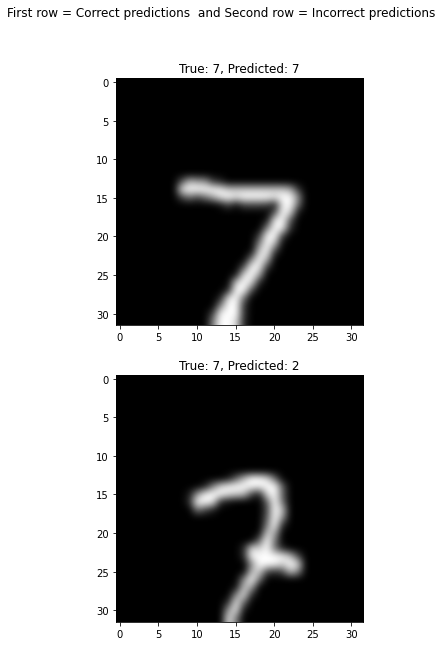

In [19]:
show_loss(Losses, save=True, path=save_dir + '/CIFAR_SGoogleNet_Losses.png')
show_accuracy(Accuracy, save=True, path=save_dir + '/CIFAR_SGoogleNet_Accuracy.png')
show_result(model, (epoch + 1),show = True, save=True, path=path)

# GoogleNet on CIFAR

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pickle
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

class Inception(nn.Module):

    def __init__(self, in_channels, out_1x1, reduce_3x3, out_3x3, reduce_5x5, out_5x5, out_pool):
        super(Inception, self).__init__()
        
        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_3x3, kernel_size=1),
            nn.Conv2d(reduce_3x3, out_3x3, kernel_size=3, padding=1)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_5x5, kernel_size=1),
            nn.Conv2d(reduce_5x5, out_5x5, kernel_size=5, padding=2)
        )

        # 3x3 pool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)
    
    
# Define the GoogleNet model
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(1024, self.num_classes)
   
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = F.relu(x)
        x = self.inception3b(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = F.relu(x)
        x = self.inception4b(x)
        x = F.relu(x)
        x = self.inception4c(x)
        x = F.relu(x)
        x = self.inception4d(x)
        x = F.relu(x)
        x = self.inception4e(x)
        x = F.relu(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = F.relu(x)
        x = self.inception5b(x)
        x = F.relu(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

In [21]:
def show_result(model, num_epoch, show=False, save=False, path='result.png'):
    """  Visualize model predictions for a sample of test data
    
    Args:
    - model (torch.nn.Module): trained PyTorch model
    - num_epoch (int): number of training epochs completed
    - show (bool): whether to display the plot inline (default: False)
    - save (bool): whether to save the plot as an image (default: False)
    - path (str): path to save the plot image (default: 'result.png')
    
    
    """
   
    classes = test_data.classes
    with torch.no_grad():            
        images, labels = next(iter(test_loader))
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Plot correct and incorrect predictions
        correct_idxs = np.where(predicted.cpu() == labels.cpu())[0]
        incorrect_idxs = np.where(predicted.cpu() != labels.cpu())[0]

        # Only show the figure if there are incorrect predictions
        if len(incorrect_idxs) > 1:

            # If there are less than 5 incorrect predictions, adjust the number of subplots accordingly
            n_plots = min(5, len(incorrect_idxs))

             # Create a figure with two rows of plots
            fig, axs = plt.subplots(2, n_plots, figsize=(20, 10))
            fig.suptitle('First row = Correct predictions  and Second row = Incorrect predictions')

            # Plot correct predictions
            for i, idx in enumerate(correct_idxs[:n_plots]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[0, i].imshow(img,interpolation='bicubic')
                axs[0, i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img,dataformats='HWC', 
                                  global_step=num_epoch)

            # Plot incorrect predictions
            for i, idx in enumerate(incorrect_idxs[:n_plots]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[1, i].imshow(img,interpolation='bicubic')
                axs[1, i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HWC', 
                                  global_step=num_epoch)
        else:
            fig, axs = plt.subplots(1, 5, figsize=(20, 10))
            fig.suptitle('Correct Predictions')
            for i, idx in enumerate(correct_idxs[:5]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[i].imshow(img,interpolation='bicubic')
                axs[i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HWC', 
                                  global_step=num_epoch)

        if save:
            fig.savefig(path)
        if show:
            fig.show()
        else:
            plt.close()

def show_loss(hist, show=False, save=False, path='Losses.png'):
    """
    Function to plot and display/save the training and testing loss values over epochs during model training.

    Args:
        hist (dict): Dictionary containing the training and testing loss values over epochs.
        show (bool): Flag to display the plot. Default is False.
        save (bool): Flag to save the plot. Default is False.
        path (str): Path to save the plot. Default is 'Losses.png'.

    Returns:
        None
    """
    # Extract x-axis values (epochs) from the history dictionary
    x = range(len(hist['Test_losses']))

     # Extract y-axis values (losses) from the history dictionary
    y1 = hist['Test_losses']
    y2 = hist['Train_losses']

     # Plot the losses using matplotlib
    plt.plot(x, y1, label='Test_losses')
    plt.plot(x, y2, label='Train_losses')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Set the legend position and display grid
    plt.legend(loc=4)
    plt.grid(True)
    
    # Set the plot layout and save the plot if save  is True
    plt.tight_layout()

    if save:
        plt.savefig(path)
    # Display the plot if show  is True, else close the plot
    if show:
        plt.show()
    else:
        plt.close()

def show_accuracy(hist, show=False, save=False, path='Accuracy.png'):
    """
    Plot the training and validation accuracy over epochs from a history dictionary.

    Parameters:
        hist (dict): A dictionary containing the training and validation accuracy values for each epoch.
        show (bool): Whether to display the plot. Default is False.
        save (bool): Whether to save the plot to a file. Default is False.
        path (str): The file path for saving the plot. Default is 'Accuracy.png'.

    Returns:
        None
    """

     # Extract accuracy values from history dictionary
    x = range(len(hist['Test_accuracy']))

    y1 = hist['Test_accuracy']
    y2 = hist['Train_accuracy']

    # Plot accuracy curves
    plt.plot(x, y1, label='Test_accuracy')
    plt.plot(x, y2, label='Train_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    # Save plot to file if specified
    if save:
        plt.savefig(path)

     # Display plot if specified
    if show:
        plt.show()
    else:
        plt.close()

In [22]:
if __name__ == '__main__':
    # initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = './CIFAR10_data/'
    save_dir = './CIFAR10_SGoogleNet_results/'
    image_save_dir = './CIFAR10_SGoogleNet_results/results'

    # create folder if not exist
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(image_save_dir):
        os.mkdir(image_save_dir)

    # training parameters
    batch_size = 128
    learning_rate = 0.01
    epochs = 100    
    
    #Load CIFAR10 dataset

    transform = transforms.Compose([transforms.Pad(2),transforms.RandomCrop(32, padding=4),transforms.ToTensor(),
        transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std  = [ 0.229, 0.224, 0.225 ]) ])

    train_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_data = datasets.CIFAR10(root='./data', train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model = GoogLeNet().to(device)

    # Define the optimizer and loss function
    optimizer = optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9,weight_decay=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 6,factor =0.1)
    loss_function = nn.CrossEntropyLoss().to(device)
 
    # Train the model

    
    def weights_init(m):
    # initialise both linear and convolutional layers
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_normal_(m.weight)   
    model.apply(weights_init)
    # tracking variables
    Losses = {}
    Losses['Test_losses'] = []
    Losses['Train_losses'] = []
    Losses['per_epoch_ptimes'] = []
    Losses['total_ptime'] = []
    Accuracy = {}
    Accuracy['Test_accuracy'] = []
    Accuracy['Train_accuracy'] = []
    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_epoch_array = []
        running_train_loss = 0.0
        epoch_start_time = time.time()
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)   
          
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            train_loss = loss_function(outputs, labels)

            # Backward pass
            train_loss.backward()

            # Update the parameters
            optimizer.step()

            running_train_loss += train_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()


        train_epoch_loss = running_train_loss/len(train_loader)    
            
        train_accuracy = 100 * train_correct / train_total    
        # print(f"Training Accuracy: {train_accuracy}%")
        
        
        model.eval()
        test_correct = 0
        test_total = 0
        test_loss_epoch_array = []
        running_test_loss = 0.0        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                test_loss = loss_function(outputs, labels)

                running_test_loss += test_loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
        test_epoch_loss =running_test_loss/len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        # print(f"Testing Accuracy: {test_accuracy}%") 

        
        

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        # print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        # print("Training loss: %.8f, Testing loss: %.8f" % (train_epoch_loss, test_epoch_loss))

        path = image_save_dir + '/CIFAR10_SGoogleNet_' + str(epoch + 1) + '.png'
        # show_result(model, (epoch + 1), save=True, path=path)

        # record the loss for every epoch
        Losses['Train_losses'].append(train_epoch_loss)
        Losses['Test_losses'].append(test_epoch_loss)
        Losses['per_epoch_ptimes'].append(per_epoch_ptime)
        Accuracy['Test_accuracy'].append(test_accuracy)
        Accuracy['Train_accuracy'].append(train_accuracy)
        scheduler.step(train_loss)
         # Add scalars to TensorBoard
        writer.add_scalar('Loss/Train', train_epoch_loss, epoch)
        writer.add_scalar('Loss/Test', test_epoch_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
        
        # Plot loss and accuracy
        writer.add_scalars('Loss', {'Train': train_epoch_loss, 'Test': test_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
        writer.flush()
        
        
        temp  = scheduler.state_dict()
        Lr = temp['_last_lr'][0]
        
        table_data = [
        ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed','Learning Rate'],
        [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime,f'{ Lr:.8f}']
        ]
        
        # table_data = [
        # ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed'],
        # [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime]
        # ]
        
        # Define colors for each column
        colors = ['\033[31m', '\033[32m', '\033[33m', '\033[34m', '\033[35m', '\033[36m','\033[37m']

        # Print the table with separators and colors
        for i, row in enumerate(table_data):
            for j, col in enumerate(row):
                print(f'| {colors[j]}{str(col).ljust(21)}\033[0m', end='')
            print('|')
            if i == 0:
                print('|', end='')
                for j in range(len(row)):
                    print('-' * 22, end='|')
                print()
        
    end_time = time.time()
    total_ptime = end_time - start_time
    Losses['total_ptime'].append(total_ptime)

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (
        np.mean(Losses['per_epoch_ptimes']), epochs, total_ptime))
    with open(save_dir + '/Losses.pkl', 'wb') as f1:
        pickle.dump(Losses, f1)
    with open(save_dir + '/Accuracy.pkl', 'wb') as f2:
        pickle.dump(Accuracy, f2)

    writer.close()

Files already downloaded and verified


100%|██████████| 391/391 [00:33<00:00, 11.64it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 1 of 100             | 22.0                 | 28.58                | 2.0248064214311294   | 1.8020610085016564   | 37.86414074897766    | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.40it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 2 of 100             | 35.266               | 40.46                | 1.6824239285095879   | 1.5861441576028172   | 38.542548179626465   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.64it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 3 of 100             | 44.362               | 49.26                | 1.487729304281952    | 1.3900793639919427   | 37.989351987838745   | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.44it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 4 of 100             | 52.06                | 53.55                | 1.3072678475733608   | 1.275857142255276    | 38.578001260757446   | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 5 of 100             | 57.526               | 60.26                | 1.181786909889992    | 1.123564830309228    | 38.926307916641235   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.55it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 6 of 100             | 62.41                | 61.24                | 1.0605710927787644   | 1.0783154798459402   | 38.087655782699585   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.50it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 7 of 100             | 65.116               | 62.8                 | 0.9912129305207821   | 1.0437720848035208   | 38.216633796691895   | 0.01000000           |


100%|██████████| 391/391 [00:32<00:00, 11.86it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 8 of 100             | 67.164               | 66.4                 | 0.9296879766847167   | 0.9739226532887809   | 37.25254464149475    | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 9 of 100             | 68.786               | 70.19                | 0.888287594098874    | 0.8621712093111835   | 38.30672812461853    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.67it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 10 of 100            | 70.774               | 70.52                | 0.8372411384911793   | 0.8463600315625155   | 37.652031660079956   | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.42it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 11 of 100            | 72.334               | 70.6                 | 0.7952141202319308   | 0.8508223627187028   | 38.424259424209595   | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 12 of 100            | 73.742               | 72.07                | 0.7601720728837621   | 0.8115968243985237   | 38.36343741416931    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.55it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 13 of 100            | 74.806               | 72.73                | 0.729850975448823    | 0.8009480230415924   | 38.0004563331604     | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 14 of 100            | 75.436               | 73.45                | 0.7092764913426031   | 0.7667402821251109   | 38.43863296508789    | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.36it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 15 of 100            | 76.79                | 75.11                | 0.6746252538907863   | 0.7425556273400029   | 38.568387031555176   | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.43it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 16 of 100            | 77.428               | 73.48                | 0.6549000762917502   | 0.7793980018247532   | 38.352147340774536   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 17 of 100            | 77.98                | 73.8                 | 0.6361983077757803   | 0.7771844094312643   | 38.12771034240723    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 18 of 100            | 78.788               | 75.5                 | 0.6109216675886413   | 0.7282300904581819   | 37.866493463516235   | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.34it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 19 of 100            | 79.37                | 74.91                | 0.6008992879591939   | 0.7544788212715825   | 38.75160574913025    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 20 of 100            | 80.216               | 76.37                | 0.5813046476572675   | 0.6976727752745906   | 37.68473744392395    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.53it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 21 of 100            | 80.474               | 75.84                | 0.5666902519552909   | 0.7388728347760213   | 38.13102912902832    | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.44it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 22 of 100            | 80.916               | 77.64                | 0.551720838869929    | 0.6610152178172823   | 38.45552659034729    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.53it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 23 of 100            | 81.644               | 75.95                | 0.5339631246178961   | 0.7140773357469824   | 38.02946472167969    | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 24 of 100            | 81.71                | 74.91                | 0.5344994904287635   | 0.7418236279789405   | 37.900845527648926   | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.34it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 25 of 100            | 82.394               | 77.47                | 0.5148460286505082   | 0.6847225250322607   | 38.563411235809326   | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 26 of 100            | 83.03                | 75.24                | 0.4971394170733059   | 0.7268173211737524   | 37.982969760894775   | 0.01000000           |


100%|██████████| 391/391 [00:34<00:00, 11.39it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 27 of 100            | 82.7                 | 77.04                | 0.5039289285002462   | 0.6804014300998253   | 38.5311963558197     | 0.01000000           |


100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 28 of 100            | 83.178               | 78.1                 | 0.4849762865497023   | 0.6585913436322273   | 37.9348566532135     | 0.00100000           |


100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 29 of 100            | 87.96                | 80.83                | 0.3491688651578201   | 0.5821499847158601   | 38.280808448791504   | 0.00100000           |


100%|██████████| 391/391 [00:34<00:00, 11.34it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 30 of 100            | 88.896               | 80.79                | 0.3205683955070003   | 0.593717561492437    | 38.84131169319153    | 0.00100000           |


100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 31 of 100            | 89.306               | 81.46                | 0.3060240277929989   | 0.5879859184917016   | 38.29044508934021    | 0.00100000           |


100%|██████████| 391/391 [00:34<00:00, 11.39it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 32 of 100            | 89.698               | 80.95                | 0.29934663792400407  | 0.6041735640809506   | 38.52249264717102    | 0.00100000           |


100%|██████████| 391/391 [00:34<00:00, 11.43it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 33 of 100            | 89.964               | 81.34                | 0.29034981341160776  | 0.5884879778457593   | 38.36386728286743    | 0.00100000           |


100%|██████████| 391/391 [00:34<00:00, 11.45it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 34 of 100            | 90.162               | 81.48                | 0.2824252633678029   | 0.5849307383163066   | 38.427589654922485   | 0.00100000           |


100%|██████████| 391/391 [00:34<00:00, 11.36it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 35 of 100            | 90.624               | 81.04                | 0.272701712215648    | 0.605439151766934    | 38.63663196563721    | 0.00100000           |


100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 36 of 100            | 90.678               | 81.04                | 0.2717669351631418   | 0.6164805417573904   | 37.97992563247681    | 0.00100000           |


100%|██████████| 391/391 [00:33<00:00, 11.53it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 37 of 100            | 90.79                | 80.77                | 0.2661903965884767   | 0.6172142247610455   | 38.16211485862732    | 0.00010000           |


100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 38 of 100            | 91.476               | 81.48                | 0.24826538284568836  | 0.6006448600865617   | 38.25920820236206    | 0.00010000           |


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 39 of 100            | 91.6                 | 81.4                 | 0.24463947174494224  | 0.6005409642865386   | 37.60845136642456    | 0.00010000           |


100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 40 of 100            | 91.57                | 81.95                | 0.24525387707116353  | 0.5957471309583399   | 37.79903817176819    | 0.00010000           |


100%|██████████| 391/391 [00:33<00:00, 11.69it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 41 of 100            | 91.574               | 81.65                | 0.24431878118716238  | 0.5957706680026236   | 37.60383152961731    | 0.00010000           |


100%|██████████| 391/391 [00:33<00:00, 11.66it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 42 of 100            | 91.474               | 81.23                | 0.24623958644507182  | 0.6087695522398888   | 37.71818828582764    | 0.00010000           |


100%|██████████| 391/391 [00:33<00:00, 11.54it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 43 of 100            | 91.552               | 81.73                | 0.24466850164601261  | 0.6022461871557598   | 37.96115779876709    | 0.00010000           |


100%|██████████| 391/391 [00:33<00:00, 11.65it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 44 of 100            | 91.614               | 81.1                 | 0.24234272895947748  | 0.6085747831229922   | 37.84007906913757    | 0.00001000           |


100%|██████████| 391/391 [00:33<00:00, 11.70it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 45 of 100            | 91.706               | 81.39                | 0.24066803779672175  | 0.5962374274489246   | 37.55391001701355    | 0.00001000           |


100%|██████████| 391/391 [00:33<00:00, 11.69it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 46 of 100            | 91.834               | 81.71                | 0.2373435476132671   | 0.6010278399232067   | 37.55856204032898    | 0.00001000           |


100%|██████████| 391/391 [00:34<00:00, 11.43it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 47 of 100            | 91.714               | 81.7                 | 0.24172742055047808  | 0.5966098463233513   | 38.57882905006409    | 0.00001000           |


100%|██████████| 391/391 [00:33<00:00, 11.73it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 48 of 100            | 91.75                | 81.45                | 0.2404510287944313   | 0.6039191216607637   | 37.46755051612854    | 0.00001000           |


100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 49 of 100            | 91.874               | 81.68                | 0.23753823734381618  | 0.6061432731302479   | 38.30398178100586    | 0.00001000           |


100%|██████████| 391/391 [00:34<00:00, 11.29it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 50 of 100            | 91.756               | 81.37                | 0.23816657087305929  | 0.6136655498154556   | 38.80211353302002    | 0.00001000           |


100%|██████████| 391/391 [00:34<00:00, 11.32it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 51 of 100            | 91.734               | 81.76                | 0.2392033590837513   | 0.5972691676284694   | 38.69943642616272    | 0.00000100           |


100%|██████████| 391/391 [00:34<00:00, 11.32it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 52 of 100            | 91.81                | 81.72                | 0.23782399853172204  | 0.6041095962252798   | 38.78763246536255    | 0.00000100           |


100%|██████████| 391/391 [00:34<00:00, 11.39it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 53 of 100            | 91.904               | 81.19                | 0.23631621546605053  | 0.6149737804750853   | 38.59949040412903    | 0.00000100           |


100%|██████████| 391/391 [00:34<00:00, 11.29it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 54 of 100            | 91.716               | 81.74                | 0.24123874504852783  | 0.603797431233563    | 38.82580494880676    | 0.00000100           |


100%|██████████| 391/391 [00:34<00:00, 11.41it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 55 of 100            | 91.818               | 81.44                | 0.23734476901304996  | 0.6048078895369663   | 38.500988721847534   | 0.00000100           |


100%|██████████| 391/391 [00:32<00:00, 11.92it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 56 of 100            | 92.066               | 81.22                | 0.23288423926247964  | 0.6103922166401827   | 36.79812455177307    | 0.00000100           |


100%|██████████| 391/391 [00:32<00:00, 11.96it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 57 of 100            | 91.878               | 81.37                | 0.23616794199513658  | 0.5988342988340161   | 36.600979804992676   | 0.00000100           |


100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 58 of 100            | 91.744               | 80.89                | 0.23721304328164175  | 0.6127120048939427   | 36.23142075538635    | 0.00000010           |


100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 59 of 100            | 91.84                | 81.7                 | 0.2367292014915315   | 0.601631349400629    | 36.240294218063354   | 0.00000010           |


100%|██████████| 391/391 [00:32<00:00, 12.06it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 60 of 100            | 91.984               | 81.37                | 0.23479604406658647  | 0.6055867600290081   | 36.31296420097351    | 0.00000010           |


100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 61 of 100            | 91.948               | 81.6                 | 0.23798420728015168  | 0.5926279029514216   | 36.37062907218933    | 0.00000010           |


100%|██████████| 391/391 [00:32<00:00, 12.10it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 62 of 100            | 91.794               | 81.83                | 0.23883298405296052  | 0.606489939780175    | 36.2497136592865     | 0.00000010           |


100%|██████████| 391/391 [00:32<00:00, 12.16it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 63 of 100            | 91.976               | 81.47                | 0.23510839917775614  | 0.6101713995390301   | 36.06741189956665    | 0.00000010           |


100%|██████████| 391/391 [00:32<00:00, 12.03it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 64 of 100            | 91.786               | 81.65                | 0.23912521396451594  | 0.6013117010080362   | 36.48330616950989    | 0.00000010           |


100%|██████████| 391/391 [00:32<00:00, 11.99it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 65 of 100            | 91.84                | 81.3                 | 0.23800485457300835  | 0.6081939060476762   | 36.53124761581421    | 0.00000010           |


100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 66 of 100            | 91.85                | 81.54                | 0.23778720203872836  | 0.5993282247947741   | 36.27347254753113    | 0.00000010           |


100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 67 of 100            | 91.778               | 81.19                | 0.23989702280982375  | 0.608507520413097    | 36.38204741477966    | 0.00000010           |


100%|██████████| 391/391 [00:32<00:00, 12.00it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 68 of 100            | 91.916               | 81.27                | 0.23844833005114893  | 0.6061463386197633   | 36.531105756759644   | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.19it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 69 of 100            | 91.774               | 81.18                | 0.2366671102393009   | 0.6118358815018135   | 36.054035902023315   | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.73it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 70 of 100            | 91.994               | 81.88                | 0.23710733798839856  | 0.5979916958869258   | 37.410735845565796   | 0.00000001           |


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 71 of 100            | 91.798               | 81.17                | 0.23849698805900485  | 0.6031692554301853   | 38.880738258361816   | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.06it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 72 of 100            | 91.862               | 81.64                | 0.23708556638196912  | 0.6129800081253052   | 36.38621115684509    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.05it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 73 of 100            | 91.752               | 81.55                | 0.23859184841289544  | 0.6004844326761705   | 36.43146896362305    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.03it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 74 of 100            | 91.862               | 81.37                | 0.2373797618748282   | 0.6047698338575      | 36.64427924156189    | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 75 of 100            | 91.844               | 81.32                | 0.2377119244021528   | 0.610267207215104    | 36.908154010772705   | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 76 of 100            | 91.89                | 81.36                | 0.23866122854335228  | 0.6009788611267186   | 37.80585241317749    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 11.92it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 77 of 100            | 91.834               | 81.72                | 0.23833771038543233  | 0.6059401650217515   | 36.74910283088684    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 78 of 100            | 91.726               | 81.42                | 0.23847741637464678  | 0.6123216872728323   | 36.33550405502319    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.09it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 79 of 100            | 91.75                | 81.97                | 0.24126947753112335  | 0.6002670847162416   | 36.29686450958252    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 11.98it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 80 of 100            | 91.842               | 81.94                | 0.2377252886476724   | 0.6094668756557416   | 36.556041955947876   | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 81 of 100            | 91.734               | 81.49                | 0.23909302593192175  | 0.6123490578766111   | 37.639774322509766   | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.72it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 82 of 100            | 91.906               | 81.01                | 0.2341229980216002   | 0.6048114971269535   | 37.467854261398315   | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.72it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 83 of 100            | 91.79                | 81.47                | 0.2368259623913509   | 0.602792515596257    | 37.480518102645874   | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 84 of 100            | 91.818               | 81.75                | 0.23609480421866297  | 0.6110517778728581   | 37.53641200065613    | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.80it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 85 of 100            | 91.988               | 81.54                | 0.23690351436052787  | 0.6072167769263063   | 37.03744387626648    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 86 of 100            | 91.702               | 81.63                | 0.241320475345225    | 0.6089152037342892   | 36.168620109558105   | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.09it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 87 of 100            | 91.774               | 81.67                | 0.24024233462103187  | 0.6172218982931934   | 36.29335355758667    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.10it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 88 of 100            | 91.8                 | 81.56                | 0.23980767687644494  | 0.5950678801989253   | 36.23378539085388    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 89 of 100            | 91.758               | 81.16                | 0.23909468542965476  | 0.608186499604696    | 36.20842957496643    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 11.92it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 90 of 100            | 91.656               | 81.09                | 0.2388486184961046   | 0.6136984579925295   | 36.97756600379944    | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 91 of 100            | 92.066               | 81.66                | 0.23546938081760235  | 0.596671756309799    | 37.89915227890015    | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.74it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 92 of 100            | 91.714               | 81.72                | 0.23843481951891005  | 0.5943796898745284   | 37.44505763053894    | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.69it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 93 of 100            | 91.708               | 81.56                | 0.2407749021030448   | 0.609842060110237    | 37.58360576629639    | 0.00000001           |


100%|██████████| 391/391 [00:33<00:00, 11.73it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 94 of 100            | 91.944               | 81.51                | 0.23462453509306969  | 0.5986374318599701   | 37.444180488586426   | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.03it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 95 of 100            | 91.698               | 81.77                | 0.2410542148229716   | 0.5984385047532335   | 36.59360861778259    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 11.98it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 96 of 100            | 91.774               | 81.83                | 0.23664787813754337  | 0.6000741501397724   | 36.55214262008667    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 11.86it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 97 of 100            | 91.78                | 81.68                | 0.2405511479243598   | 0.5962417453904695   | 36.907196044921875   | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.20it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 98 of 100            | 91.792               | 81.72                | 0.24051056870871493  | 0.6043969954870925   | 35.97497487068176    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 99 of 100            | 91.724               | 81.34                | 0.23811183187662793  | 0.600362040196793    | 36.28717017173767    | 0.00000001           |


100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 100 of 100           | 91.932               | 81.73                | 0.23537927612547985  | 0.6028286003613774   | 36.08053016662598    | 0.00000001           |
Avg per epoch ptime: 37.55, total 100 epochs ptime: 3755.18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

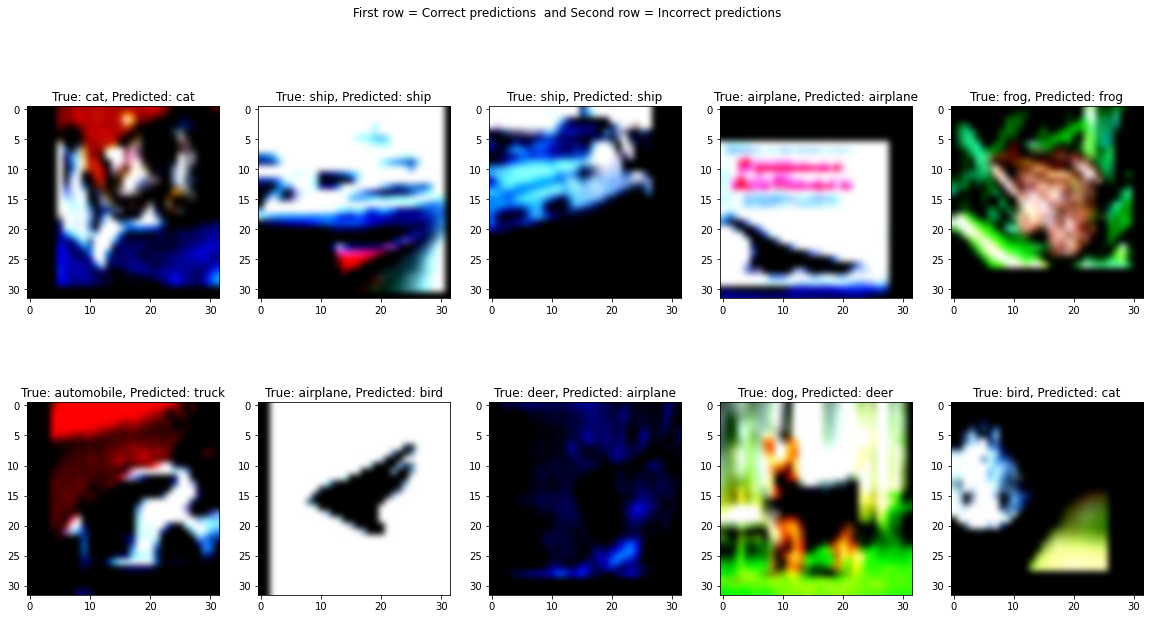

In [23]:
show_loss(Losses, save=True, path=save_dir + '/CIFAR_SGoogleNet_Losses.png')
show_accuracy(Accuracy, save=True, path=save_dir + '/CIFAR_SGoogleNet_Accuracy.png')
show_result(model, (epoch + 1),show = True, save=True, path=path)